# Time-Dependent Variational Principle (TDVP)
This notebook demonstrates the capabilities of our implemented TDVP algorithm, if the underlying tensor network structure is a chain, i.e. in matrix product form. A matrix product state (MPS) is a binary tree. Therefore, we can simulate it using `PyTreeNet`. We recommend to use tensor network libraries specialised on MPS for serious simulation, due to a higher efficiency. However, utilising `PyTreeNet` on MPS is useful as an illustrative example and to test the code for mistakes, by comparing to the results yielded by the easy to implement few-site dynamics.

In [1]:
from copy import deepcopy

# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

X, Y, Z = ptn.common_operators.pauli_matrices()

## TDVP: A single qubit rotation on a Bloch Sphere
We use a simple Hamiltonian $H=X$ on a single qubit that is initially in the zero state $\ket{\psi} = \ket{0}$.

In [2]:
state = ptn.TreeTensorNetworkState()
tensor = np.array([1,0],dtype=complex)
single_node = ptn.Node(identifier="qubit")
state.add_root(single_node,tensor)
print(state.nodes)
print(state.tensors)

{'qubit': <pytreenet.node.Node object at 0x7f151eeeeb50>}
{'qubit': array([1.+0.j, 0.+0.j])}


In [3]:
ham = ptn.TTNO()
single_ham_node = ptn.Node(identifier="qubit")
ham.add_root(single_ham_node, deepcopy(X))
print(ham.nodes)
print(ham.tensors)

{'qubit': <pytreenet.node.Node object at 0x7f151eeeefd0>}
{'qubit': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}


Then we set up the TDVP algorithm.

In [4]:
time_step_size = 0.001
final_time = 1
operators = ptn.TensorProduct({"qubit": Z})

In [5]:
tdvp = ptn.FirstOrderOneSiteTDVP(state, ham,time_step_size, final_time,
                                 operators)
tdvp.run(evaluation_time=10)

100%|██████████| 1001/1001 [00:00<00:00, 3711.26it/s]


Now we run an exact reference copmutation:

In [6]:
ref_state = np.array([1,0],dtype=complex)
ref_ham = X
operator = Z
num_time_steps = tdvp.num_time_steps
ref_results = np.zeros_like(tdvp.results)
for time_step in range(num_time_steps+1):
    if time_step != 0:
        ref_state = ptn.fast_exp_action(-1j*time_step_size*ref_ham, ref_state)
    if time_step % 10 == 0:
        ref_results[0,time_step//10] = np.conjugate(ref_state) @ operator @ ref_state
        ref_results[-1,time_step//10] = time_step * time_step_size

In [7]:
# All expectation values are real
print(np.allclose(np.imag(tdvp.results),np.zeros_like(tdvp.results)))
print(np.allclose(np.imag(ref_results),np.zeros_like(ref_results)))

times = np.real(tdvp.results[-1,:])
ref_results = np.real(ref_results[0,:])
tdvp_results = np.real(tdvp.results[0,:])

True
True


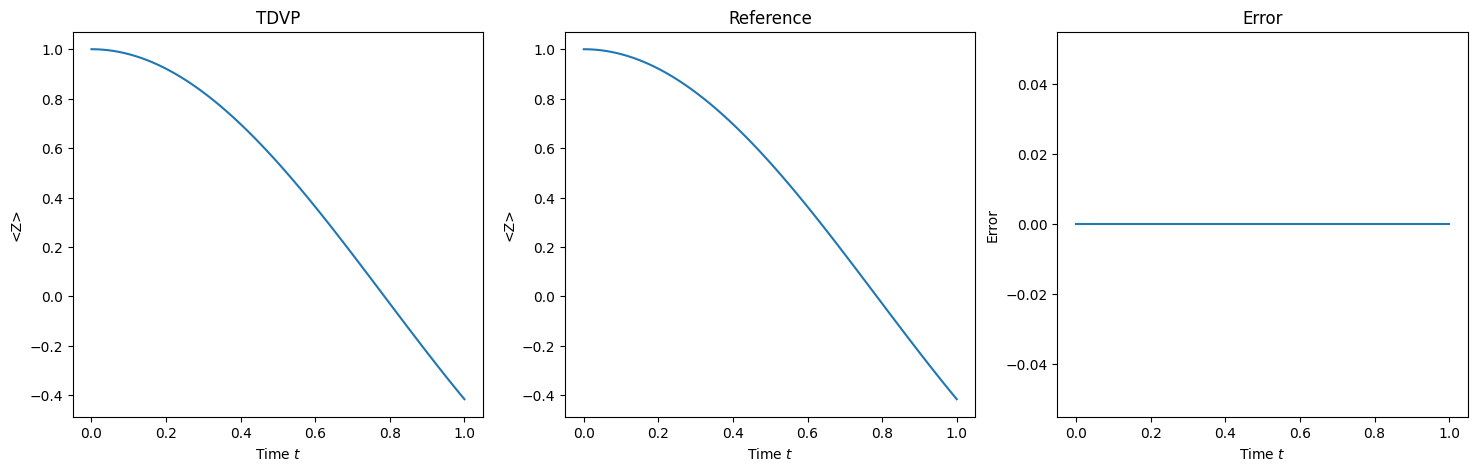

In [8]:
fig1, axs1 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs1[0].plot(times, tdvp_results)
axs1[0].set_xlabel("Time $t$")
axs1[0].set_ylabel("<Z>")
axs1[0].set_title("TDVP")

axs1[1].plot(times, ref_results)
axs1[1].set_xlabel("Time $t$")
axs1[1].set_ylabel("<Z>")
axs1[1].set_title("Reference")

axs1[2].plot(times, ref_results - tdvp_results)
axs1[2].set_xlabel("Time $t$")
axs1[2].set_ylabel("Error")
axs1[2].set_title("Error")

plt.show()

# TDVP with MPS: Two Qubit system evolving under Heisenberg Hamiltonian
This time we consider the Heisenberg like Hamiltonian on two qubits given by
$$
H = -J X_0X_1 -g (Z_0 + Z_1),
$$
where $X_i$ and $Z_i$ are the Pauli operators acting on qubit $i$. We start in the zero state
$$
\ket{\psi} = \ket{0}_0 \otimes \ket{0}_1.
$$

In [9]:
num_sites = 2
mJ = -1.5
mg = -0.5

In [10]:
mps = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[1])
print(mps.nodes.keys())

dict_keys(['site0', 'site1'])


In [11]:
interaction_term = ptn.TensorProduct({"site0": "mJX", "site1": "X"})
single_site_terms = [ptn.TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
terms = [interaction_term]
terms.extend(single_site_terms)
conversion_dict = {"mJX": mJ * X,
                   "X": X,
                   "mgZ": mg * Z,
                   "I2": np.eye(2)}

In [12]:
hamiltonian = ptn.Hamiltonian(terms, conversion_dict)
hamiltonian = hamiltonian.pad_with_identities(mps)
hamiltonian

[{'site0': 'mJX', 'site1': 'X'}, {'site0': 'mgZ', 'site1': 'I2'}, {'site1': 'mgZ', 'site0': 'I2'}]

In [13]:
ham_ttno = ptn.TTNO.from_hamiltonian(hamiltonian, mps)
operators = [ptn.TensorProduct({"site"+str(i): Z}) for i in range(num_sites)]

In [14]:
tdvp = ptn.FirstOrderOneSiteTDVP(mps,ham_ttno,
                                 time_step_size,final_time,
                                 operators)
tdvp.run(evaluation_time=10,pgbar=True)

  0%|          | 0/1001 [00:00<?, ?it/s]

100%|██████████| 1001/1001 [00:01<00:00, 669.21it/s]


Now we run an exact reference simulation

In [15]:
ref_state = np.array([1,0,0,0],dtype=complex)
ref_ham = np.kron(conversion_dict["mJX"], conversion_dict["X"])
ref_ham += np.kron(conversion_dict["I2"], conversion_dict["mgZ"])
ref_ham += np.kron(conversion_dict["mgZ"], conversion_dict["I2"])
operator0 = np.kron(Z,np.eye(2))
operator1 = np.kron(np.eye(2),Z)
num_time_steps = tdvp.num_time_steps
ref_results = np.zeros_like(tdvp.results)
for time_step in range(num_time_steps+1):
    if time_step != 0:
        ref_state = ptn.fast_exp_action(-1j*time_step_size*ref_ham, ref_state)
    if time_step % 10 == 0:
        ref_results[0,time_step//10] = np.conjugate(ref_state) @ operator0 @ ref_state
        ref_results[1,time_step//10] = np.conjugate(ref_state) @ operator1 @ ref_state
        ref_results[-1,time_step//10] = time_step * time_step_size


In [16]:
# All expectation values are real
print(np.allclose(np.imag(tdvp.results),np.zeros_like(tdvp.results)))
print(np.allclose(np.imag(ref_results),np.zeros_like(ref_results)))

times = np.real(tdvp.results[-1,:])
ref_results0 = np.real(ref_results[0,:])
tdvp_results0 = np.real(tdvp.results[0,:])
ref_results1 = np.real(ref_results[1,:])
tdvp_results1 = np.real(tdvp.results[1,:])

True
True


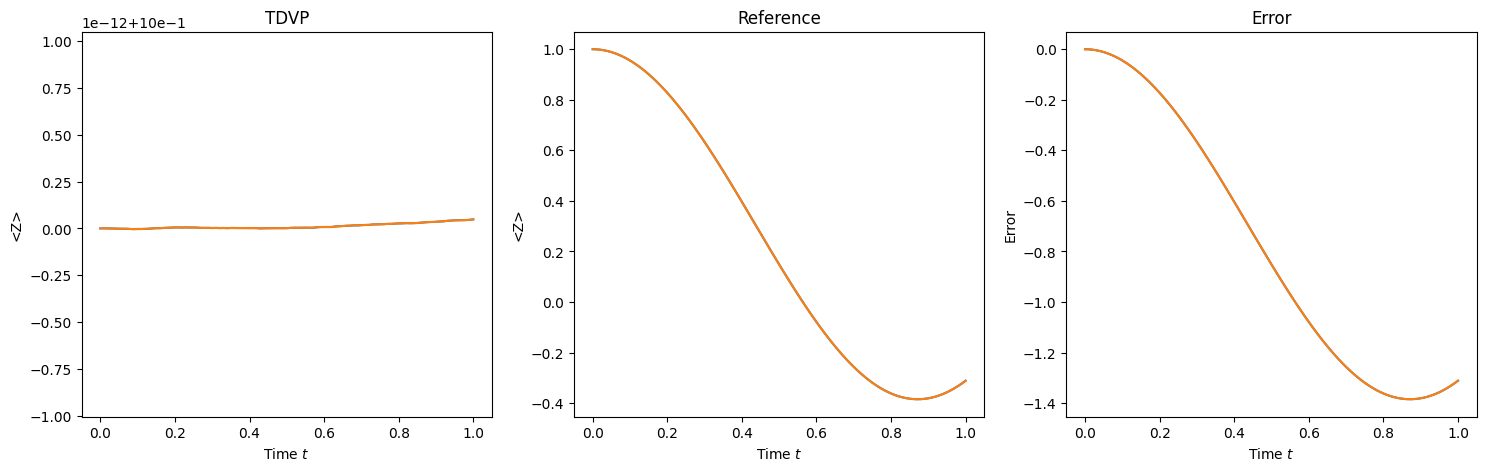

In [17]:
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp_results0)
axs2[0].plot(times, tdvp_results1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results0)
axs2[1].plot(times, ref_results1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, ref_results0 - tdvp_results0)
axs2[2].plot(times, ref_results1 - tdvp_results1)
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()

The error is large, notably because we set the bond dimension to $1$, which is smaller than required. We repeat the process with bond dimension $2$:

In [18]:
mps2 = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[2])
tdvp2 = ptn.FirstOrderOneSiteTDVP(mps2,ham_ttno,
                                 time_step_size,final_time,
                                 operators)
tdvp2.run(evaluation_time=10,pgbar=True)

100%|██████████| 1001/1001 [00:01<00:00, 589.22it/s]


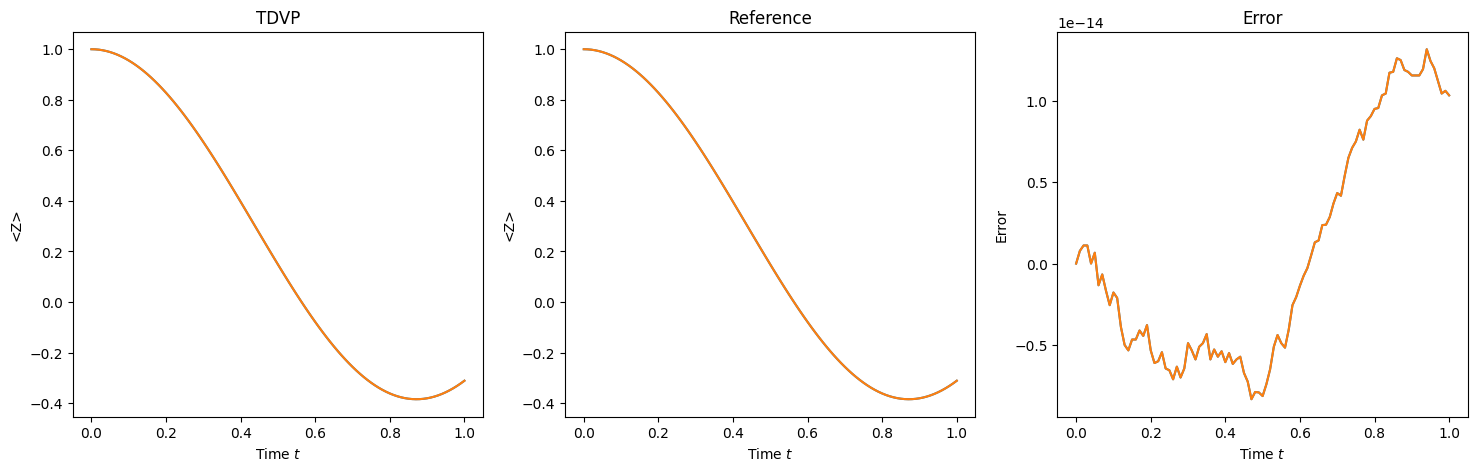

In [19]:
tdvp2_results0 = np.real(tdvp2.results[0,:])
tdvp2_results1 = np.real(tdvp2.results[1,:])
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp2_results0)
axs2[0].plot(times, tdvp2_results1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results0)
axs2[1].plot(times, ref_results1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, ref_results0 - tdvp2_results0)
axs2[2].plot(times, ref_results1 - tdvp2_results1)
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()

# TDVP with MPS: Multi-Qubit system evolving under Heisenberg Hamiltonian
This time we consider the Heisenberg like Hamiltonian on $N$-many qubits given by
$$
H = -J \sum_{i=0}^{N-2}X_i X_{i+1} -g \sum_{i=0}^{N-1} Z_i,
$$
where $X_i$ and $Z_i$ are the Pauli operators acting on qubit $i$. We start in the zero state
$$
\ket{\psi} = \bigotimes_{i=0}^{N-1} \ket{0}_i.
$$

In [22]:
num_sites = 7
mJ = -1.5
mg = -0.5

In [33]:
mps = ptn.MatrixProductState.constant_product_state(0,2,num_sites,root_site=4)

In [34]:
interaction_terms = [ptn.TensorProduct({"site"+str(site): "mJX","site"+str(site+1): "X"})
                     for site in range(num_sites-1)]
single_site_terms = [ptn.TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
terms = interaction_terms
terms.extend(single_site_terms)
conversion_dict = {"mJX": mJ * X,
                   "X": X,
                   "mgZ": mg * Z,
                   "I2": np.eye(2)}

In [35]:
hamiltonian = ptn.Hamiltonian(terms, conversion_dict)
hamiltonian = hamiltonian.pad_with_identities(mps)
for term in hamiltonian.terms:
    print(term)

{'site0': 'mJX', 'site1': 'X', 'site4': 'I2', 'site3': 'I2', 'site2': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site1': 'mJX', 'site2': 'X', 'site4': 'I2', 'site3': 'I2', 'site0': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site2': 'mJX', 'site3': 'X', 'site4': 'I2', 'site1': 'I2', 'site0': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site3': 'mJX', 'site4': 'X', 'site2': 'I2', 'site1': 'I2', 'site0': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site4': 'mJX', 'site5': 'X', 'site3': 'I2', 'site2': 'I2', 'site1': 'I2', 'site0': 'I2', 'site6': 'I2'}
{'site5': 'mJX', 'site6': 'X', 'site4': 'I2', 'site3': 'I2', 'site2': 'I2', 'site1': 'I2', 'site0': 'I2'}
{'site0': 'mgZ', 'site4': 'I2', 'site3': 'I2', 'site2': 'I2', 'site1': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site1': 'mgZ', 'site4': 'I2', 'site3': 'I2', 'site2': 'I2', 'site0': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site2': 'mgZ', 'site4': 'I2', 'site3': 'I2', 'site1': 'I2', 'site0': 'I2', 'site5': 'I2', 'site6': 'I2'}
{'site3': 'mgZ', 'site4': 'I2', 'site2': 'I

In [65]:
ham_ttno = ptn.TTNO.from_hamiltonian(hamiltonian, mps)
operators = [ptn.TensorProduct({"site"+str(i): Z}) for i in range(num_sites)]
for operator in operators:
    print(operator)

{'site0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site3': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site4': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site5': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'site6': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}


In [38]:
bond_dimensions = [6*[1],
                   6*[2],
                   [2,3,3,3,3,2],
                   [2,4,4,4,4,2],
                   [2,4,5,5,4,2],
                   [2,4,5,5,4,2],
                   [2,4,6,6,4,2],
                   [2,4,7,7,4,3],
                   [2,4,8,8,4,2]]

In [52]:
results = []
for bond_dimension in bond_dimensions:
    mps = ptn.MatrixProductState.constant_product_state(0,2,num_sites,
                                                        root_site=4,
                                                        bond_dimensions=bond_dimension)
    tdvp = ptn.FirstOrderOneSiteTDVP(mps,ham_ttno,
                                    time_step_size,final_time,
                                    operators)
    tdvp.run(evaluation_time=10,pgbar=True)
    results.append(tdvp.results)

100%|██████████| 1001/1001 [00:12<00:00, 77.28it/s]


In [53]:
# All expectation values are real
for result in results:
    print(np.allclose(np.imag(result),np.zeros_like(result)))

True
True
True
True
True
True
True
True
True


In [54]:
results = [np.real(result) for result in results]

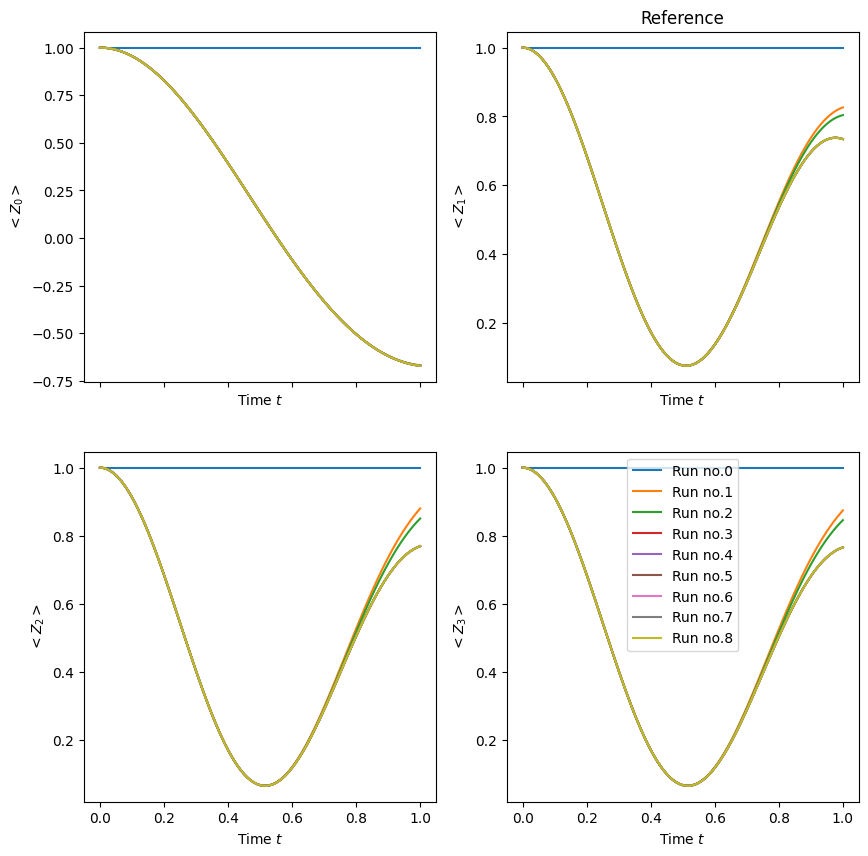

In [64]:
times = results[0][-1,:]

fig3, axs3 = plt.subplots(2,2,figsize=(10,10),sharex=True)

for i in range(len(bond_dimensions)):
    axs3[0,0].plot(times, results[i][0])
axs3[0,0].set_xlabel("Time $t$")
axs3[0,0].set_ylabel("$<Z_0>$")

for i in range(len(bond_dimensions)):
    axs3[0,1].plot(times, results[i][1])
axs3[0,1].set_xlabel("Time $t$")
axs3[0,1].set_ylabel("$<Z_1>$")
axs3[0,1].set_title("Reference")

for i in range(len(bond_dimensions)):
    axs3[1,0].plot(times, results[i][2])
axs3[1,0].set_xlabel("Time $t$")
axs3[1,0].set_ylabel("$<Z_2>$")

for i in range(len(bond_dimensions)):
    axs3[1,1].plot(times, results[i][3], label="Run no." + str(i))
axs3[1,1].set_xlabel("Time $t$")
axs3[1,1].set_ylabel("$<Z_3>$")

plt.legend()
plt.show()

We can clearly see that the result improves for an increasing bond dimension. Furthermore, we find that the accuracy reduces the longer the simulation is run. Both are as one would expect.